# Profileometer Analysis

In [1]:
import sys
import os
sys.path.insert(0, "../../python")
sys.path.insert(1, "../../../photoDAQ")

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import csv
plt.style.use('presentation')

path = '/media/robert/Data_Storage/Data/Experimental/Lithium_Oven_Optic_7/Profilometer/Etch_Test1/'

Take a profile over a periodic structure and determine the depth of the structure. I use this after spin coat, after etching, and after stripping.

Test profiles should be flattened and can include one or more sets of equally spaced line. The code will only work if each set of lines has at least one full period. If the pattern includes a single step, use the function developed for directly handling single step functions.

In [2]:
def load_profile(filename):
    profile = {}
    data = False
    units = False
    i = 0
    N = 0
    with open(path+filename, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            if len(row) > 0:
                if data and i<N:
                    x[i] = float(row[0])
                    y[i] = float(row[1])
                    i += 1
                if units: data = True #This is the units line, next is data
                if row[0] == 'Date': 
                    profile['date'] = row[1].split(' ')[0]
                    profile['time'] = row[1].split(' ')[1]
                if row[0] == 'Stylus Type': profile['radius'] = float(row[1].split(' ')[1])
                if row[0] == 'NumPts' and N == 0: 
                    N = int(row[1])
                    x = np.zeros(N)
                    y = np.zeros(N)
                    profile['N'] = N
                if row[0] == 'Force': profile['force'] = float(row[1])
                if row[0] == 'Sclen': profile['length'] = float(row[1])
                if row[0] == 'Mrange': profile['Mrange'] = row[1]
                if row[0] == 'Levpt': profile['Levpt'] = float(row[1])
                if row[0] == 'Levslp': profile['Levslp'] = float(row[1])
                if row[0] == 'Raw Data': units = True
    profile['x'] = x
    profile['y'] = y
    return profile
                
profile = load_profile('30s_PostStripTest1.txt')

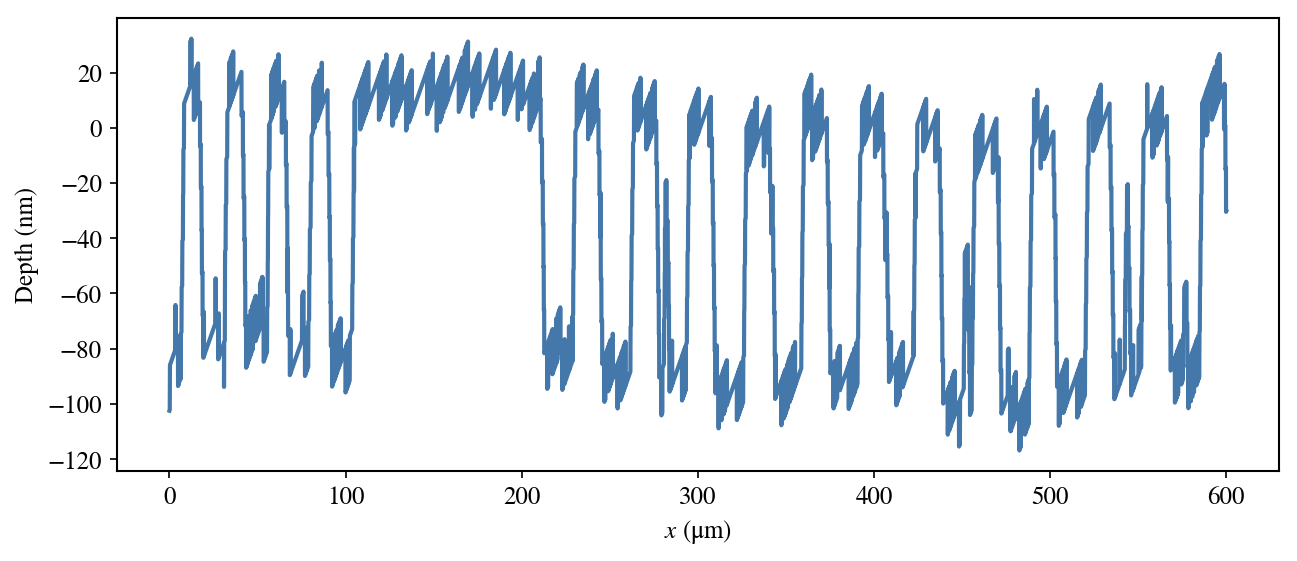

In [3]:
def plot_raw(profile):
    plt.figure(figsize=(10, 4), dpi=150)
    plt.plot(profile['x'], profile['y']/10)
    plt.xlabel(r'$x$ ($\mathrm{\mu m}$)')
    plt.ylabel(r'Depth (nm)')
    plt.show()
    
plot_raw(profile)

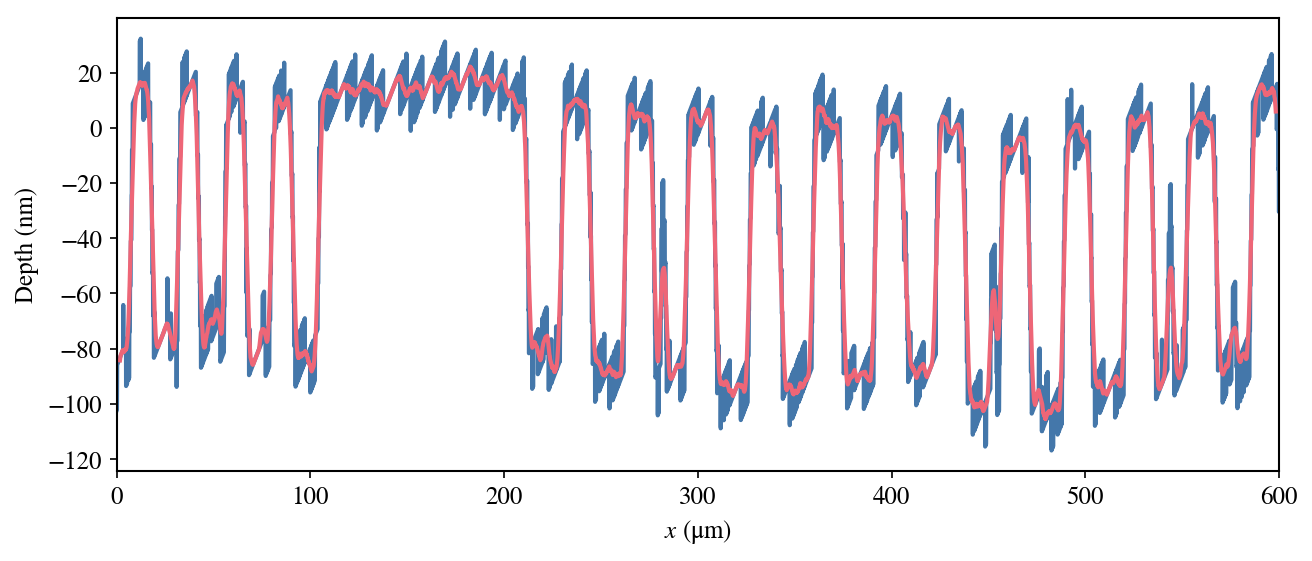

In [4]:
def smooth_data(profile, M):
    offset = int(M/2)
    y_s = np.convolve(profile['y'], np.ones((M,))/M, mode='valid')
    x_s = profile['x'][offset:-(M-offset)+1]
    plt.figure(figsize=(10, 4), dpi=150)
    plt.plot(profile['x'], profile['y']/10)
    plt.plot(x_s, y_s/10)
    plt.xlabel(r'$x$ ($\mathrm{\mu m}$)')
    plt.ylabel(r'Depth (nm)')
    plt.xlim(profile['x'][0], profile['x'][-1])
    plt.show()
    return x_s, y_s
x_s, y_s = smooth_data(profile, 70)

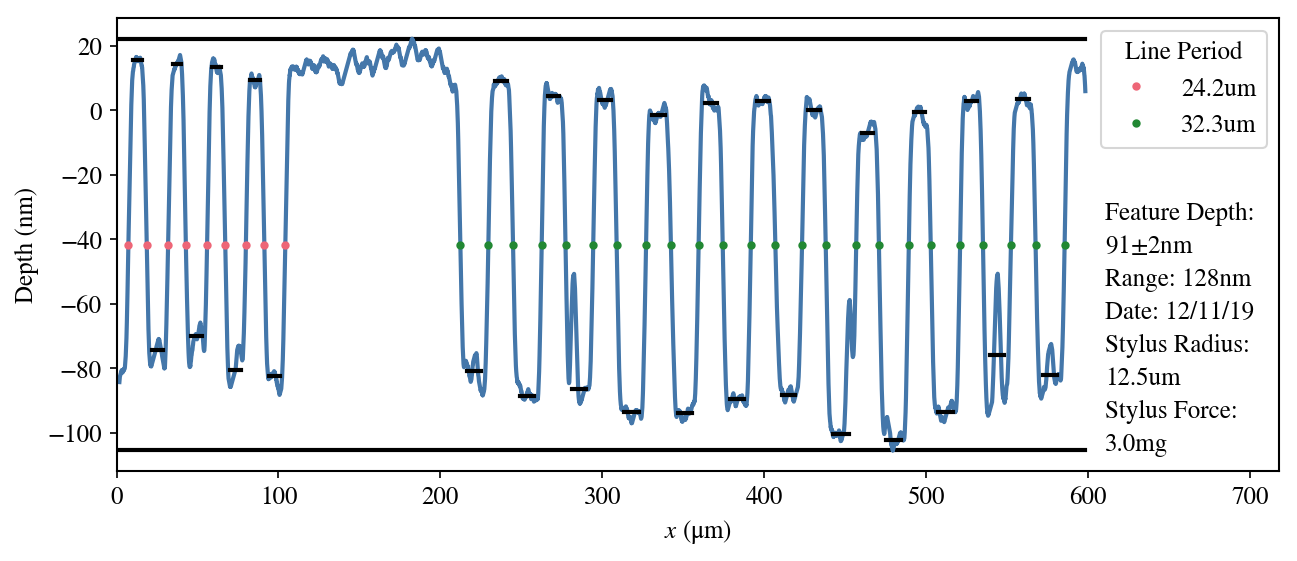

In [5]:
def feature_depth(profile, x, y, a):
    """ Calculate the depth of uniformly spaced lines. 
    
    Parameters
    ----------
    profile : dict
        The profile dictionary returned by load_profile.
    x : array of doubles
        The x values of the profile measurement.
    y : array of doubles
        The y (depth) values of the profile measurement.
    a : double
        The fraction of points in-between the half maxes to use for the peak.
    """
    y_min = np.min(y)
    y_max = np.max(y)
    middle = (y_max-y_min)*0.5 + y_min
    spline = UnivariateSpline(x, y-middle, s=0)
    roots = spline.roots()

    plt.figure(figsize=(10, 4), dpi=150)
    plt.plot(x, y/10, zorder=2)
    plt.plot([0, x[-1]], [y_max/10, y_max/10], 'k', zorder=1)
    plt.plot([0, x[-1]], [y_min/10, y_min/10], 'k', zorder=1)

    m = len(roots)
    sections = np.zeros(m)
    j = 1
    edge = False
    for i in range(m):
        if i==0:
            initial = roots[i+2]-roots[i]
            sections[i] = j
            continue
        elif i==1:
            dh = dl = roots[i+2]-roots[i]
        elif i==m-1 or i==m-2:
            dh = dl = roots[i]-roots[i-2]
        else:
            dh = roots[i+2]-roots[i]
            dl = roots[i]-roots[i-2]
        if (dh > initial*0.8 and dh < initial*1.2) or (dl > initial*0.8 and dl < initial*1.2):
            sections[i] = j
        if dh > initial*1.2:
            edge = True
        if dl > dh*1.2 and edge:
            edge = False
            initial = dh
            j += 1
            sections[i] = j

        #print(dl, dh, sections[i])

    depth = np.zeros(j)
    std = np.zeros(j)
    weight = np.zeros(j)
    for i in range(1, j+1):
        sel = sections == i
        points = roots[sel]
        delta = np.average(points[2:]-points[:-2])
        d = np.zeros(len(points-1))
        plt.plot(points, np.ones(len(points))*middle/10, '.', label='%0.1fum'%delta)
        for k in range(1, len(points)):
            r1 = points[k-1]
            r2 = points[k]
            sel = np.logical_and(x > r1, x < r2)
            x_t = x[sel]
            y_t = y[sel]
            l = len(x_t)
            x_t = x_t[int(l*(0.5-a/2)):int(l*(0.5+a/2))]
            y_t = y_t[int(l*(0.5-a/2)):int(l*(0.5+a/2))]
            d[k-1] = np.median(y_t)
            plt.plot([x_t[0], x_t[-1]], [d[k-1]/10, d[k-1]/10], 'k-')
        depth[i-1] = np.average(abs(d[1:]-d[:-1]))
        std[i-1] = np.std(abs(d[1:]-d[:-1]))
        weight[i-1] = len(points)-1

    depth = np.average(depth, weights=weight)/10
    std = np.sqrt(np.sum((weight**2*std**2)/(np.sum(weight)**2.5)))/10

    plt.legend(title='Line Period', loc=1)
    plt.xlabel(r'$x$ ($\mathrm{\mu m}$)')
    plt.ylabel(r'Depth (nm)')
    base_x = 1.02*x[-1]
    base_y = (y_max-y_min)/10
    plt.text(base_x, 0.56*base_y+y_min/10, 'Feature Depth:')
    plt.text(base_x, 0.48*base_y+y_min/10, r'%0.0f$\pm$%0.0fnm' % (depth, std))
    plt.text(base_x, 0.40*base_y+y_min/10, r'Range: %0.0fnm' % ((y_max-y_min)/10))
    plt.text(base_x, 0.32*base_y+y_min/10, 'Date: '+profile['date'])
    plt.text(base_x, 0.24*base_y+y_min/10, 'Stylus Radius:')
    plt.text(base_x, 0.16*base_y+y_min/10, str(profile['radius'])+'um')
    plt.text(base_x, 0.08*base_y+y_min/10, 'Stylus Force:')
    plt.text(base_x, 0.00*base_y+y_min/10, str(profile['force'])+'mg')

    plt.xlim(0, 1.2*x[-1])
    plt.show()
feature_depth(profile, x_s, y_s, 0.5)

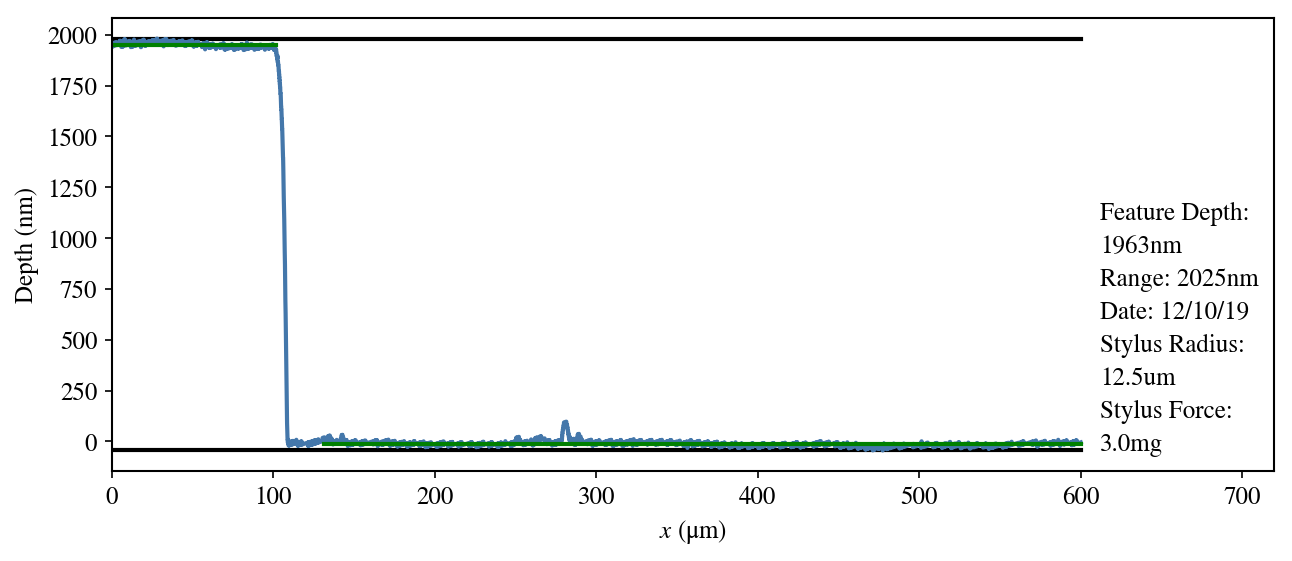

In [6]:
def step_depth(profile, x, y):
    """ Calculate the depth of a step feature. 
    
    Parameters
    ----------
    profile : dict
        The profile dictionary returned by load_profile.
    x : array of doubles
        The x values of the profile measurement.
    y : array of doubles
        The y (depth) values of the profile measurement.
    """
    y_min = np.min(y)
    y_max = np.max(y)
    middle = (y_max-y_min)*0.5 + y_min
    spline = UnivariateSpline(x, y-middle, s=0)
    roots = spline.roots()

    plt.figure(figsize=(10, 4), dpi=150)
    plt.plot(x, y/10, zorder=2)
    plt.plot([0, x[-1]], [y_max/10, y_max/10], 'k', zorder=1)
    plt.plot([0, x[-1]], [y_min/10, y_min/10], 'k', zorder=1)

    a = 0.05
    sel = x < roots[0]
    x_t = x[sel]
    y_t = y[sel]
    l = len(x_t)
    x_t = x_t[:int(l*(1-a))]
    y_t = y_t[:int(l*(1-a))]
    start = np.average(y_t)
    plt.plot([x_t[0], x_t[-1]], [start/10, start/10], 'g-')
    
    sel = x > roots[0]
    x_t = x[sel]
    y_t = y[sel]
    l = len(x_t)
    x_t = x_t[int(l*a):]
    y_t = y_t[int(l*a):]
    end = np.average(y_t)
    plt.plot([x_t[0], x_t[-1]], [end/10, end/10], 'g-')

    depth = abs(end-start)/10

    plt.xlabel(r'$x$ ($\mathrm{\mu m}$)')
    plt.ylabel(r'Depth (nm)')
    base_x = 1.02*x[-1]
    base_y = (y_max-y_min)/10
    plt.text(base_x, 0.56*base_y+y_min/10, 'Feature Depth:')
    plt.text(base_x, 0.48*base_y+y_min/10, r'%0.0fnm' % depth)
    plt.text(base_x, 0.40*base_y+y_min/10, r'Range: %0.0fnm' % ((y_max-y_min)/10))
    plt.text(base_x, 0.32*base_y+y_min/10, 'Date: '+profile['date'])
    plt.text(base_x, 0.24*base_y+y_min/10, 'Stylus Radius:')
    plt.text(base_x, 0.16*base_y+y_min/10, str(profile['radius'])+'um')
    plt.text(base_x, 0.08*base_y+y_min/10, 'Stylus Force:')
    plt.text(base_x, 0.00*base_y+y_min/10, str(profile['force'])+'mg')

    plt.xlim(0, 1.2*x[-1])
    plt.show()
profile = load_profile('30s_EtchTest4.txt')
step_depth(profile, profile['x'], profile['y'])

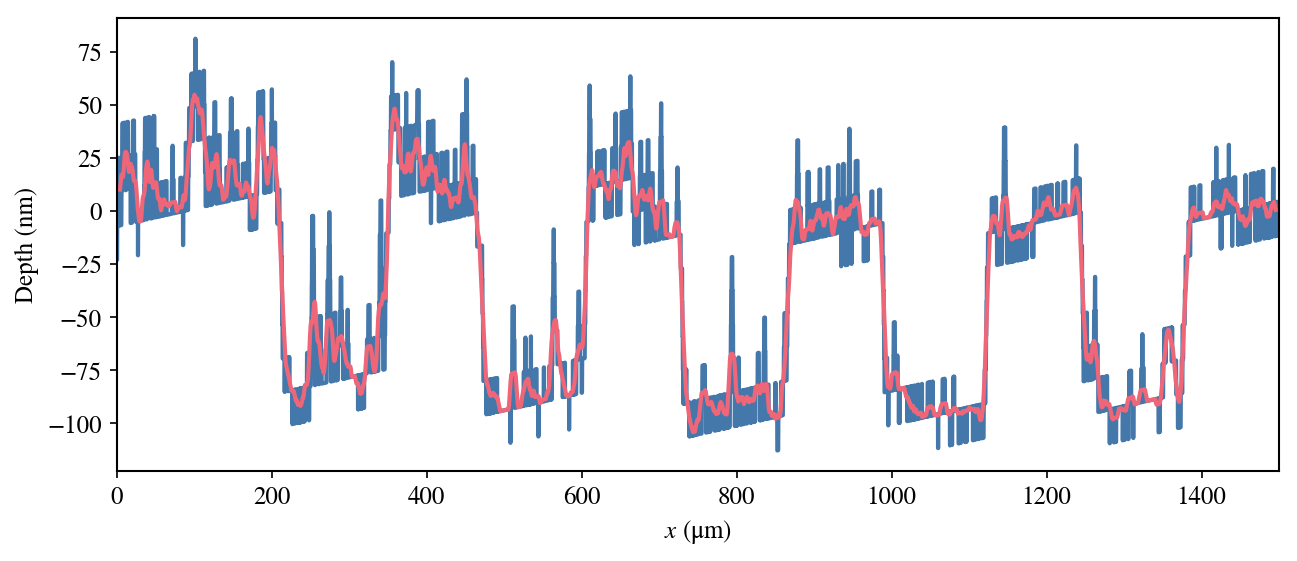

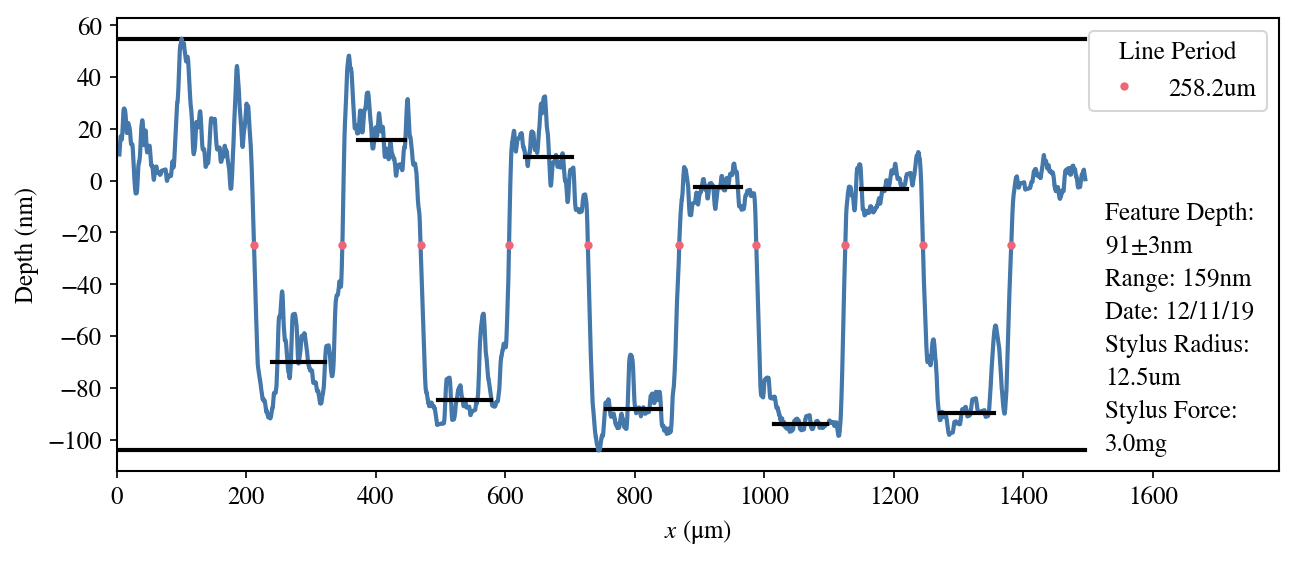

In [7]:
profile = load_profile('30s_PostStripTest2.txt')
x_s, y_s = smooth_data(profile, 70)
feature_depth(profile, x_s, y_s, 0.6)

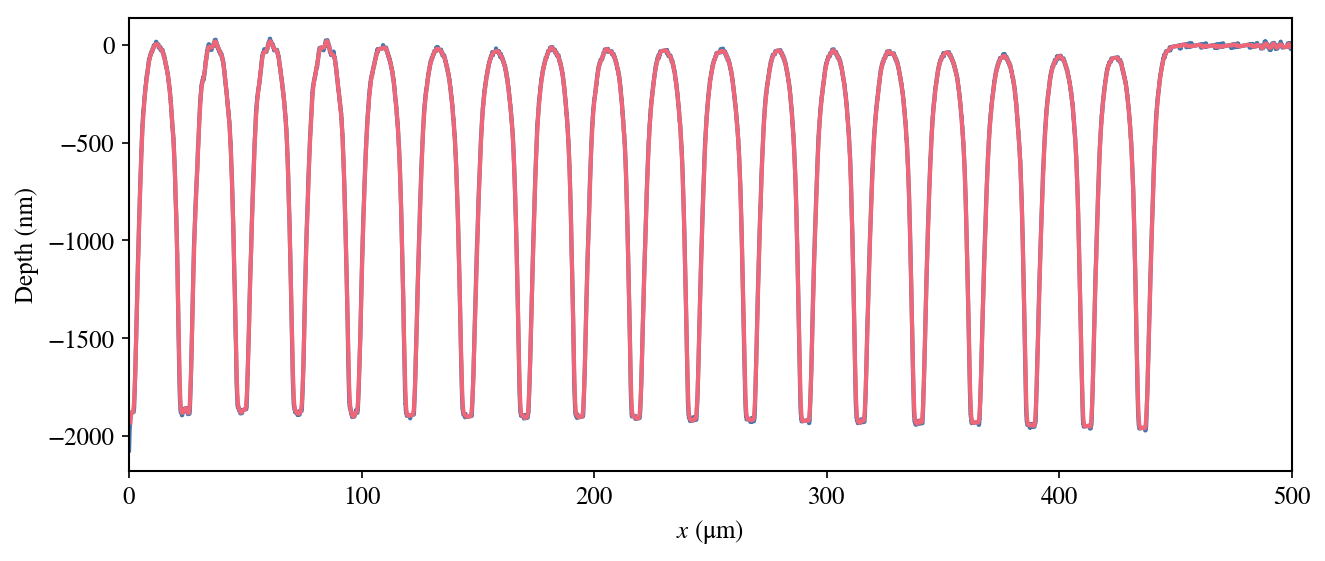

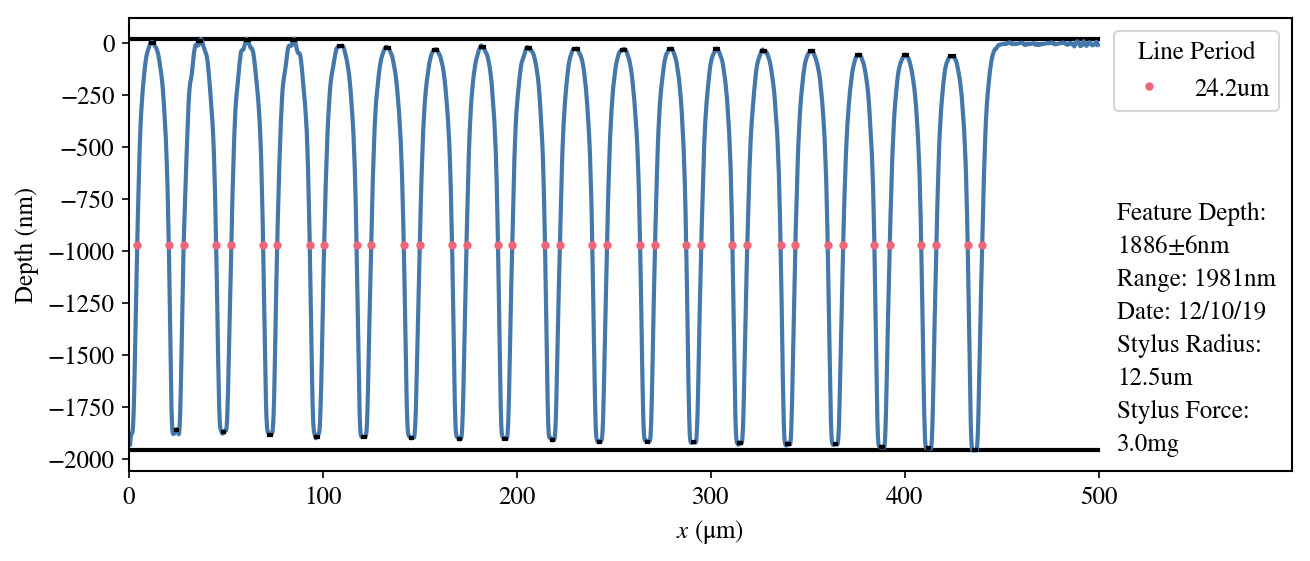

In [8]:
profile = load_profile('30s_EtchTest.txt')
x_s, y_s = smooth_data(profile, 20)
feature_depth(profile, x_s, y_s, 0.1)

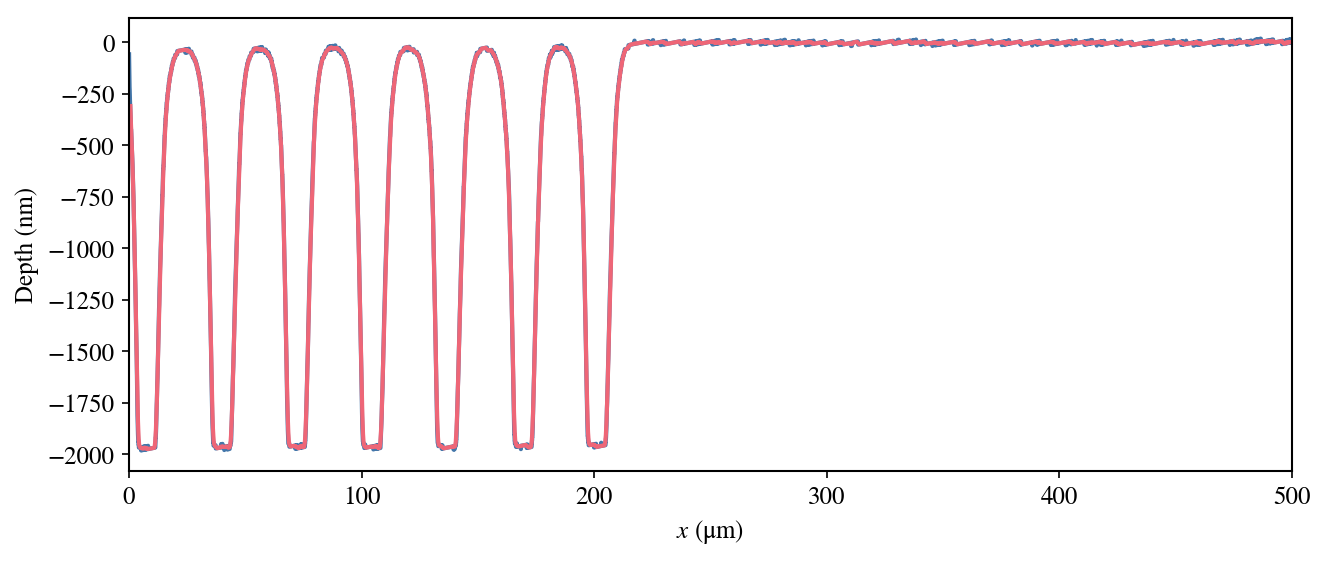

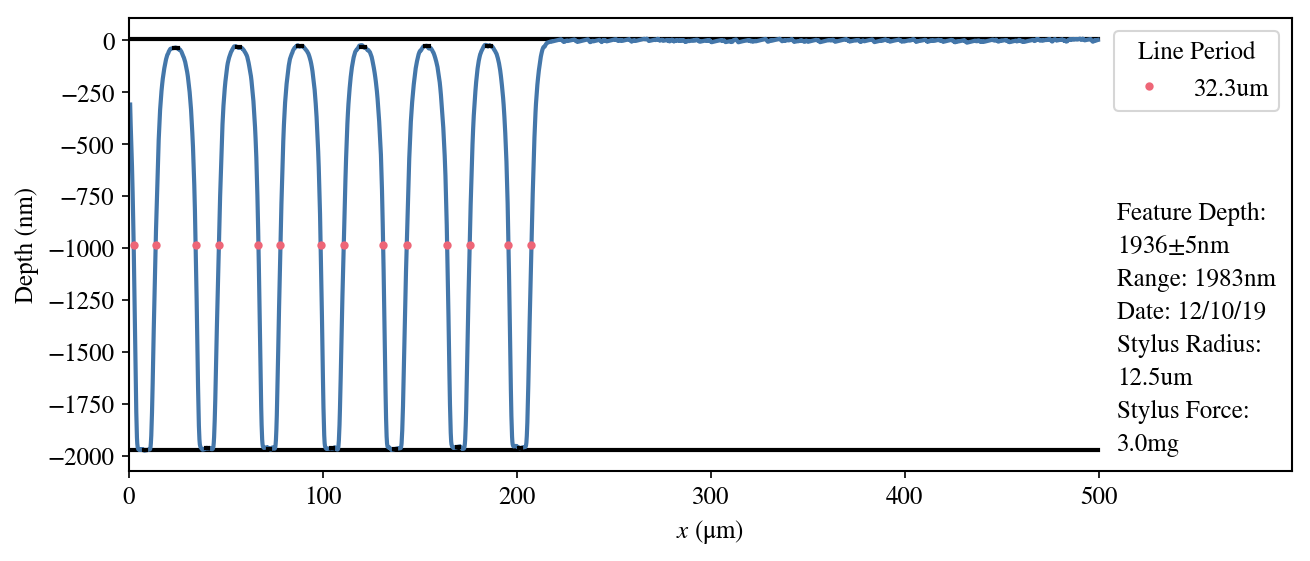

In [9]:
profile = load_profile('30s_EtchTest2.txt')
x_s, y_s = smooth_data(profile, 20)
feature_depth(profile, x_s, y_s, 0.1)

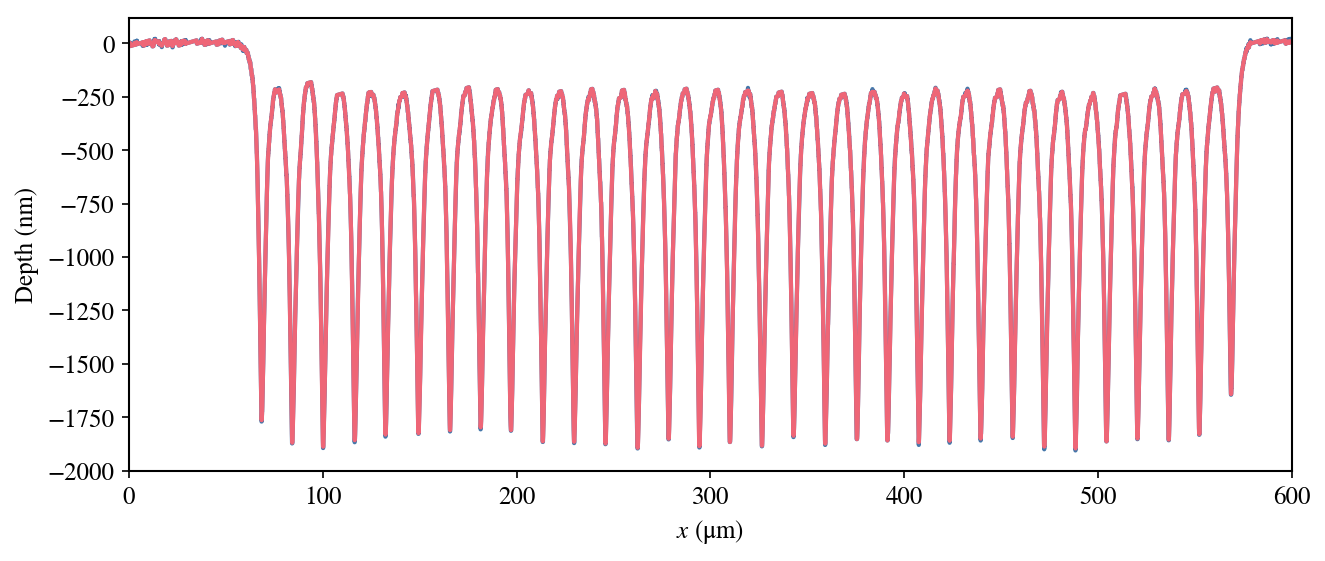

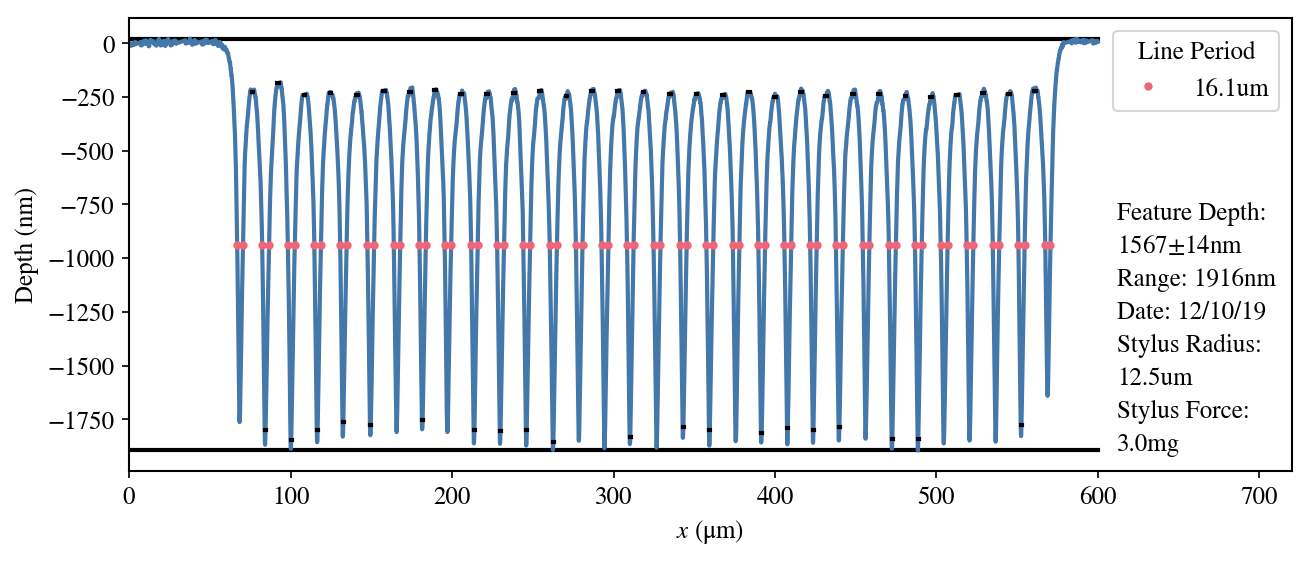

In [10]:
profile = load_profile('30s_EtchTest3.txt')
x_s, y_s = smooth_data(profile, 5)
feature_depth(profile, x_s, y_s, 0.1)

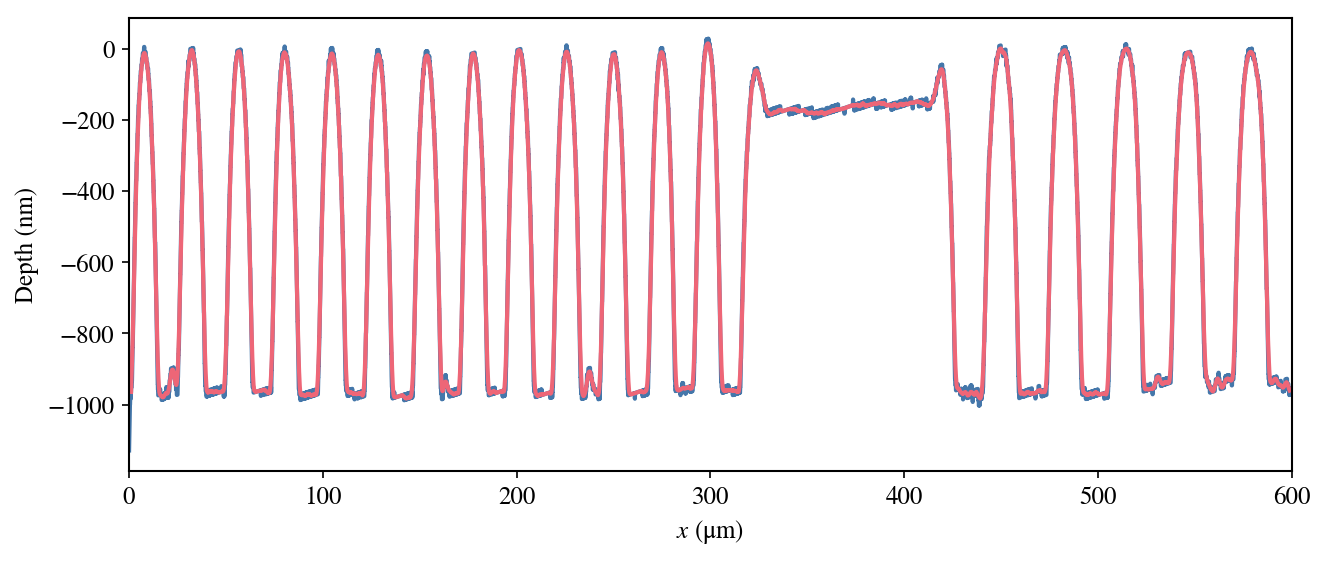

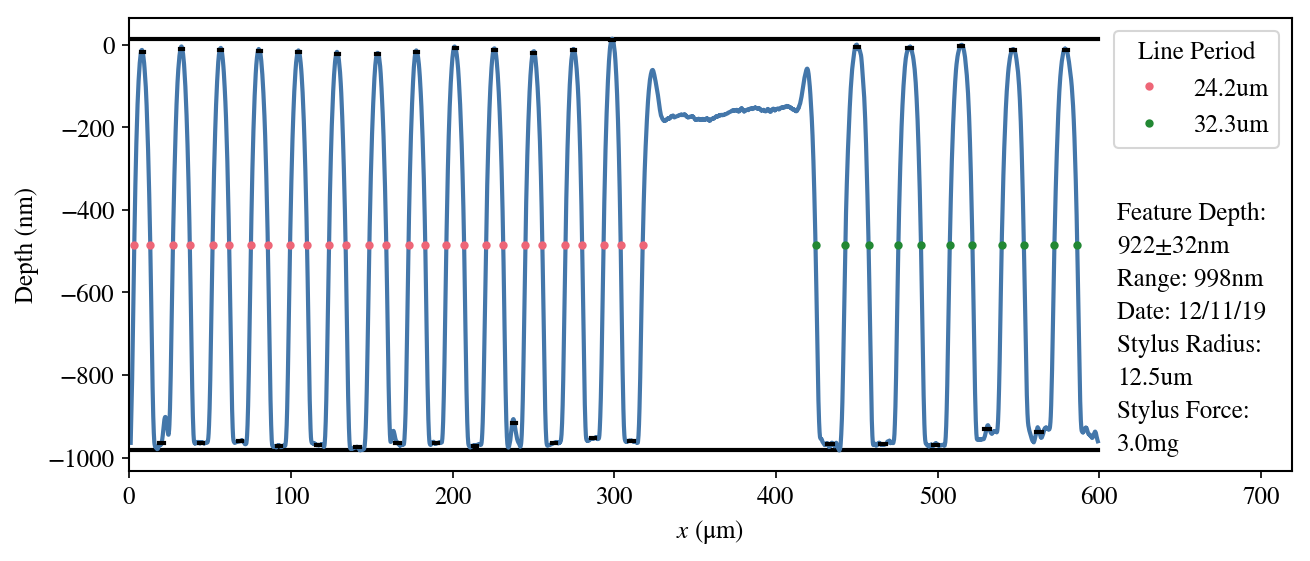

In [11]:
profile = load_profile('30s_PostEtchTest2.txt')
x_s, y_s = smooth_data(profile, 40)
feature_depth(profile, x_s, y_s, 0.2)

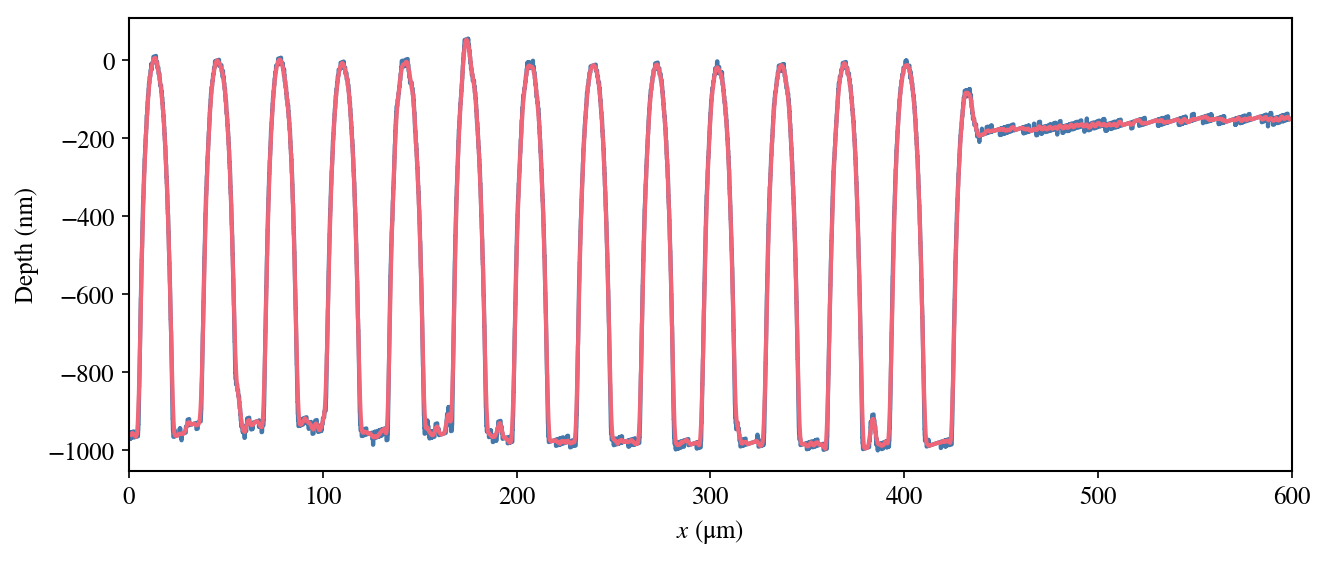

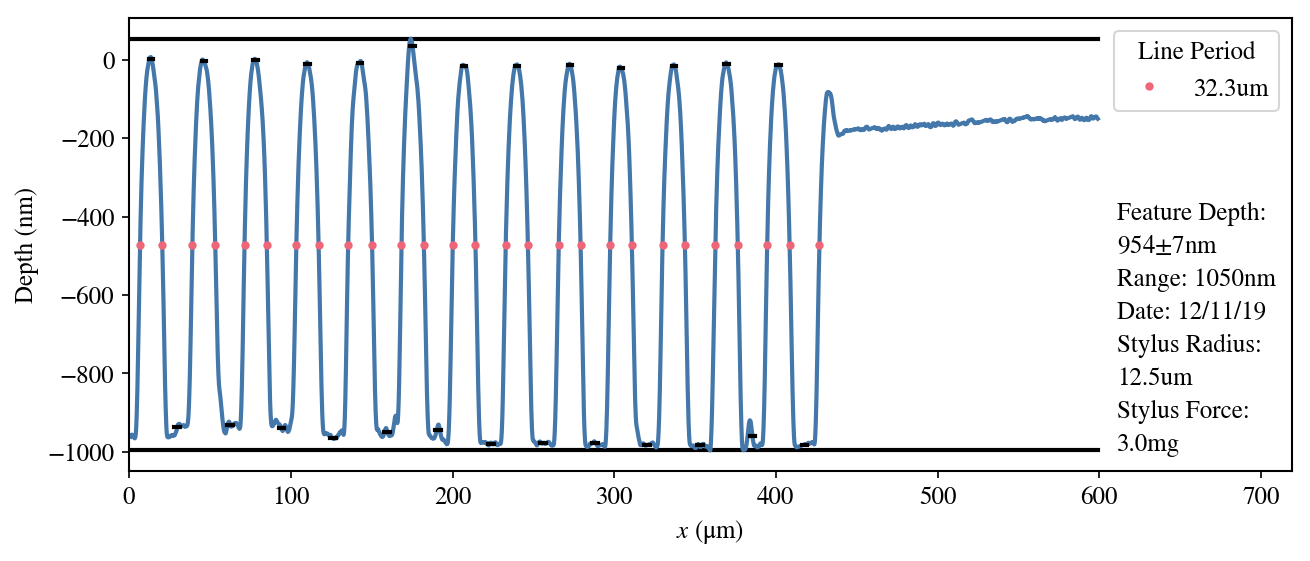

In [12]:
profile = load_profile('30s_PostEtchTest3.txt')
x_s, y_s = smooth_data(profile, 40)
feature_depth(profile, x_s, y_s, 0.2)

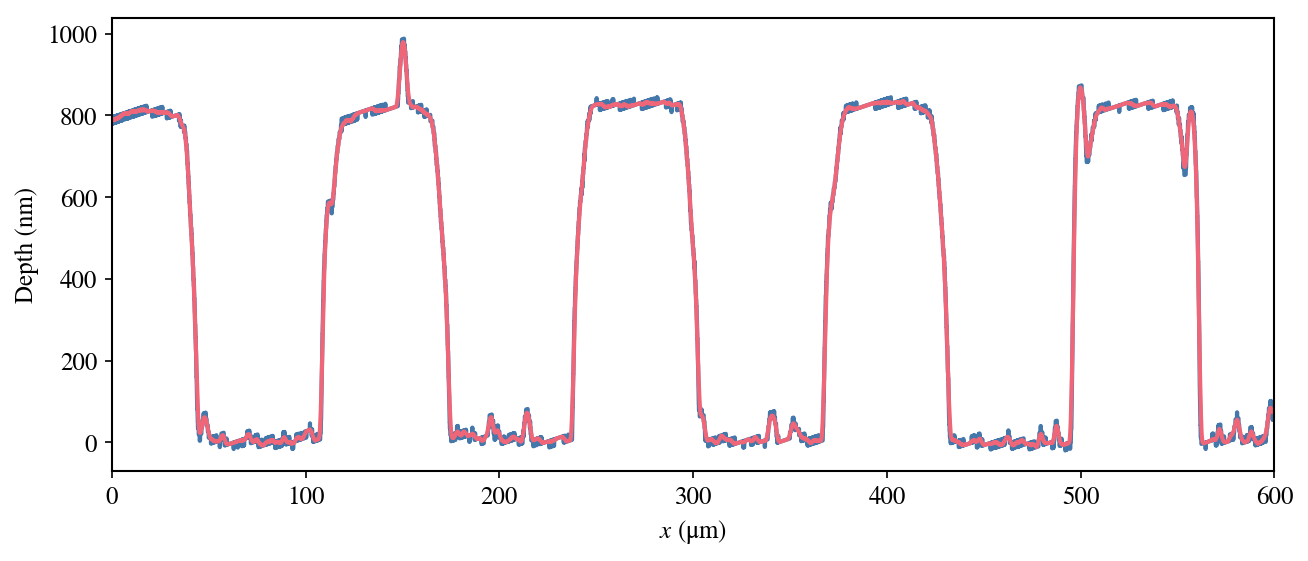

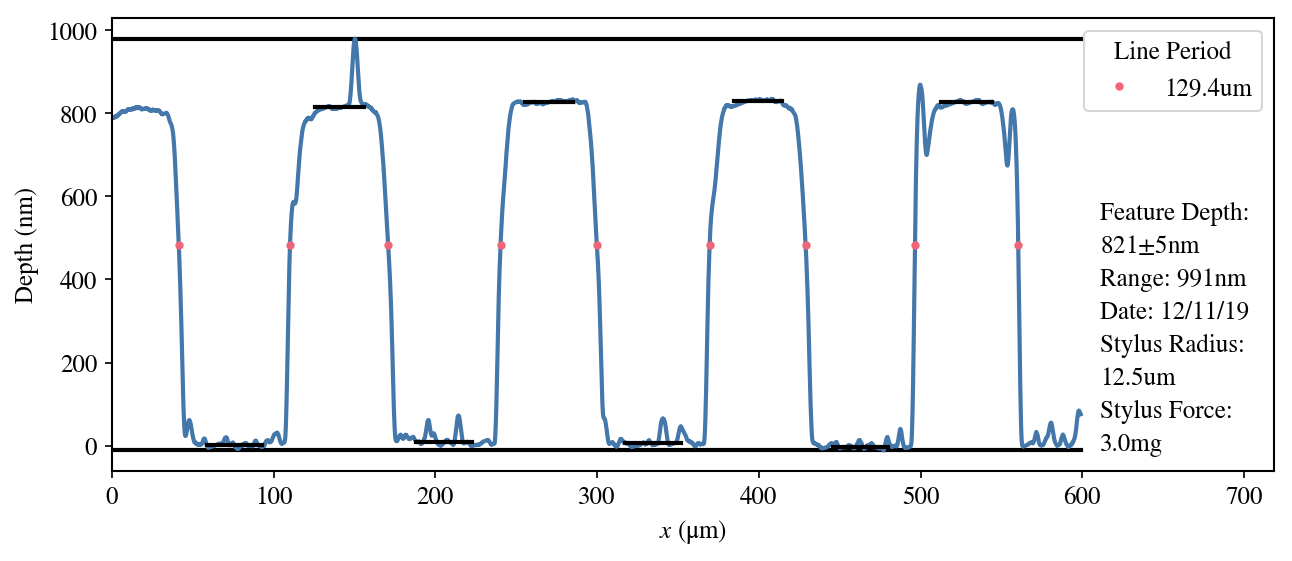

In [13]:
profile = load_profile('30s_PostEtchTest4.txt')
x_s, y_s = smooth_data(profile, 40)
feature_depth(profile, x_s, y_s, 0.5)

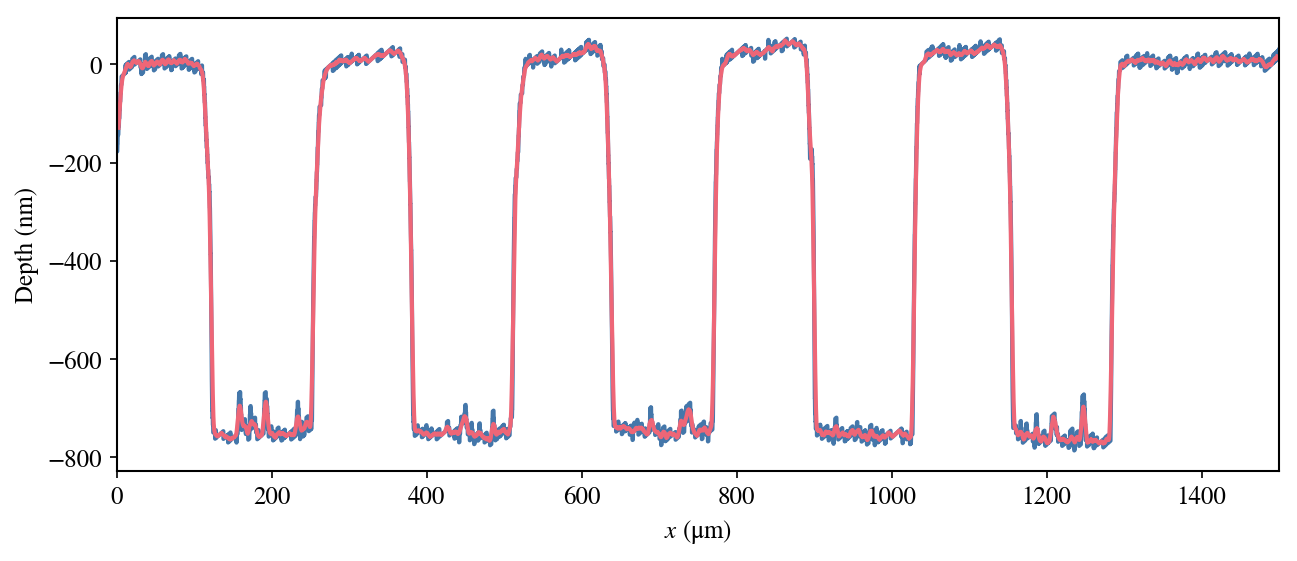

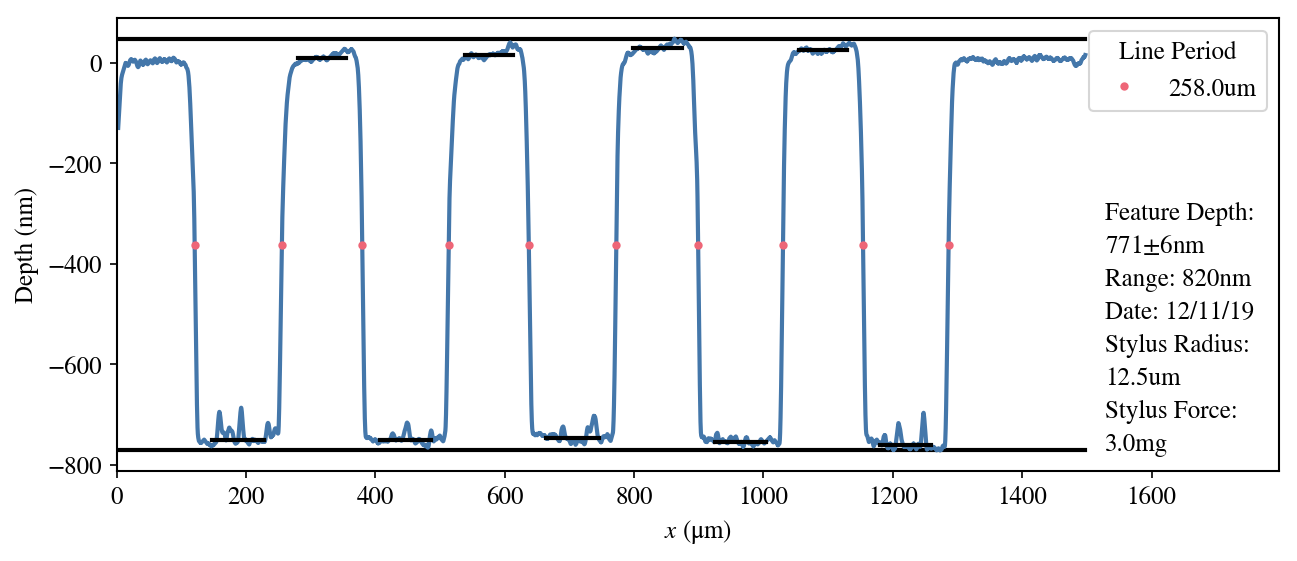

In [14]:
profile = load_profile('30s_PostEtchTest5.txt')
x_s, y_s = smooth_data(profile, 40)
feature_depth(profile, x_s, y_s, 0.6)